# Result Analysis

In [183]:
import json
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.manifold import TSNE
from os.path import join
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import euclidean
from scipy.stats import pearsonr
from sklearn.decomposition import PCA

from img2vec_pytorch import Img2Vec
from PIL import Image

In [184]:
# ./data/A_red_glass__30_gpt-4-vision-preview_dall-e-3_gpt-4-1106-preview_v0
# ./data/A_yellow_hou_30_gpt-4-vision-preview_dall-e-3_gpt-4-1106-preview_v0
# ./data/realistic_po_20_gpt-4-vision-preview_dall-e-3_gpt-4-1106-preview_v1

RUN_DIR = "/home/linus/git/uni/PromptRefining/data/realistic_po_20_gpt-4-vision-preview_dall-e-3_gpt-4-1106-preview_v1"

a = 0.9

# Get the colormap colors, multiply them with the factor "a", and create new colormap
cmap = plt.cm.BuPu(np.arange(plt.cm.BuPu.N))
cmap[:,0:3] *= a 
cmap = ListedColormap(cmap)

In [185]:
def get_vecs_of_run(dir, img2vec_model):
    vec_dict = {}
    vec_dict['diff'] = json.load(open(join(dir, "difference_embeddings.json")))
    vec_dict['prompt'] = json.load(open(join(dir, "prompt_embeddings.json")))
    vec_dict['img'] = [img2vec_model.get_vec(Image.open(os.path.join(dir, f))) for f in os.listdir(dir) if os.path.isfile(os.path.join(dir, f)) and f.endswith(".png")]

    return vec_dict


def get_tsne(embeddings, labels=None, perplexity=30.0, random_state=20, title=''):
    fig = plt.figure()
    fig.suptitle(title)

    matrix = np.array(embeddings)
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=random_state, init='pca', learning_rate=200)
    vis_dims = tsne.fit_transform(matrix)
    x = vis_dims[:,0]
    y = vis_dims[:,1]
    weights = np.arange(1, len(embeddings) + 1)
    plt.scatter(x, y, c=weights, cmap=cmap)
    if labels:
        [plt.text(i, j, l) for (i, j, l) in zip(x, y, labels)]
    plt.colorbar()

    return fig


def get_similarities(embeddings, labels=None, limit=False, title=''):
    fig = plt.figure()
    fig.suptitle(title)
    similarities = cosine_similarity(embeddings)[-1]
    x = np.arange(0, len(embeddings))
    y = similarities
    plt.scatter(x, similarities, marker='x')
    if labels:
        [plt.text(i, j, l) for (i, j, l) in zip(x, y, labels)]
    plt.xlabel("Iterations")
    plt.ylabel("Similarity")
    if limit:
        plt.ylim(0, 1)
    
    return fig


def get_euclidean_distances(embeddings, labels=None, title=''):
    fig = plt.figure()
    fig.suptitle(title)

    # calc euclidian distances of each embedding to the last one
    distances = [euclidean(embedding, embeddings[-1]) for embedding in embeddings]

    x = np.arange(len(embeddings))
    y = distances

    plt.scatter(x, y, marker='x')

    # optionally add labels
    if labels:
        [plt.text(i, j, l) for (i, j, l) in zip(x, y, labels)]

    plt.xlabel("Iterations")
    plt.ylabel("Euclidean Distance")

    return fig


def plot_embedding_magnitudes_with_correlation(img_embeddings, prompt_embeddings, labels=None, title=''):
    # clac magnitudes of embeds
    image_magnitudes = [np.linalg.norm(embedding) for embedding in img_embeddings]
    prompt_magnitudes = [np.linalg.norm(embedding) for embedding in prompt_embeddings]

    # calc pearson correlation between image and prompt magnitudes
    correlation_coefficient, _ = pearsonr(image_magnitudes, prompt_magnitudes)

    fig, ax = plt.subplots()
    title_with_correlation = f"{title} - Pearson Correlation: {correlation_coefficient:.2f}"
    fig.suptitle(title_with_correlation)

    x = np.arange(len(img_embeddings))
    ax.plot(x, image_magnitudes, marker='o', label='Difference Embeddings')
    ax.plot(x, prompt_magnitudes, marker='x', label='Prompt Embeddings')

    if labels:
        for i, label in enumerate(labels):
            ax.text(x[i], max(image_magnitudes[i], prompt_magnitudes[i]), label, fontsize=8)

    ax.set_xlabel("Iterations")
    ax.set_ylabel("Magnitude")
    ax.legend()

    return fig


def embedding_instability(embeddings):
    distances = []
    for i in range(1, len(embeddings)):
        distance = euclidean(embeddings[i], embeddings[i-1])
        distances.append(distance)
    instability = np.std(distances)
    
    return instability


def normalized_embedding_instability(embeddings):
    # instability normalized by value range
    distances = [euclidean(embeddings[i], embeddings[i-1]) for i in range(1, len(embeddings))]
    instability = np.std(distances)
    value_range = np.max(embeddings) - np.min(embeddings)
    normalized_stability = instability / value_range if value_range != 0 else 0
    return normalized_stability


def get_cosine_similarity_boxplot(embeddings, title=''):
    fig = plt.figure(figsize=(8, 6))
    fig.suptitle(title)
    # ensure 2D numpy array
    embeddings = np.array(embeddings)
    
    # calc cosine similarity of each embedding to the last one
    last_embedding = embeddings[-1].reshape(1, -1)
    similarities = cosine_similarity(embeddings, last_embedding).flatten()
    
    plt.boxplot(similarities, vert=True, patch_artist=True)
    plt.ylabel('Cosine Similarity')
    plt.xticks([1], ['Embeddings'])
    #plt.ylim(0, 1)  # cosine similarity ranges from -1 to 1 -> -1 would indicate completely opposite
    plt.grid(True)
    
    return fig


def get_pca_plot(embeddings, title=''):
    # reduce to 2 dimensions
    pca = PCA(n_components=2)
    reduced_embeddings = pca.fit_transform(embeddings)

    fig, ax = plt.subplots()
    weights = np.arange(1, len(embeddings) + 1)
    ax.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=weights, cmap=cmap)

    fig.suptitle(title)
    ax.set_xlabel('PCA Component 1')
    ax.set_ylabel('PCA Component 2')

    return fig


def measure_constant_increase(embeddings):
    embeddings = np.array(embeddings)
    
    last_embedding = embeddings[-1].reshape(1, -1)
    similarities = cosine_similarity(embeddings, last_embedding).flatten()
    differences = np.diff(similarities)
    average_difference = np.mean(differences)

    return average_difference

In [186]:
# get img vectors using img2vec
img2vec = Img2Vec(cuda=False, model = 'resnet-18')

# get all vecs
vecs = get_vecs_of_run(RUN_DIR, img2vec)

difference_embeddings = vecs['diff']
prompt_embeddings = vecs['prompt']
img_embeddings = vecs['img']

/home/linus/git/uni/PromptRefining/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/linus/git/uni/PromptRefining/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Load data from the specified directory

Print data using T-SNE

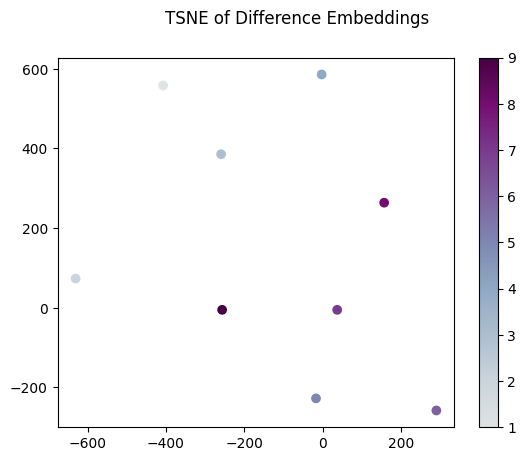

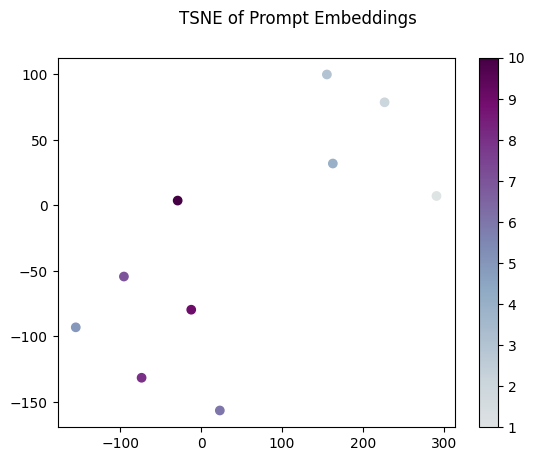

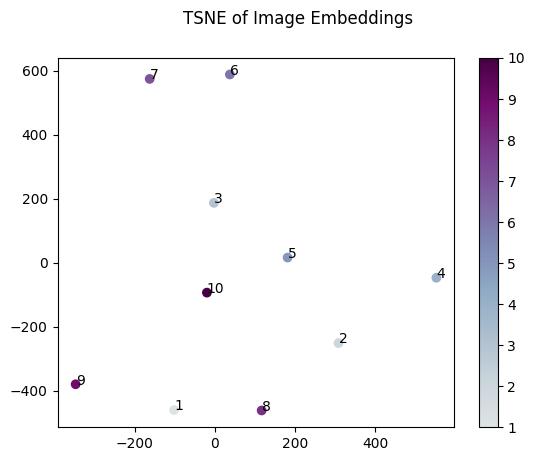

In [187]:
diff_labels = [f"{i + 1}" for i in range(0, len(difference_embeddings))]
prompt_labels = [f"{i + 1}" for i in range(0, len(prompt_embeddings))]
img_labels = [f"{i + 1}" for i in range(0, len(img_embeddings))]

diff_tsne = get_tsne(difference_embeddings, perplexity=5, title = "TSNE of Difference Embeddings")
prompts_tsne = get_tsne(prompt_embeddings, perplexity=5, title = "TSNE of Prompt Embeddings")
img_tsne = get_tsne(img_embeddings, labels=img_labels, perplexity=5, title = "TSNE of Image Embeddings")

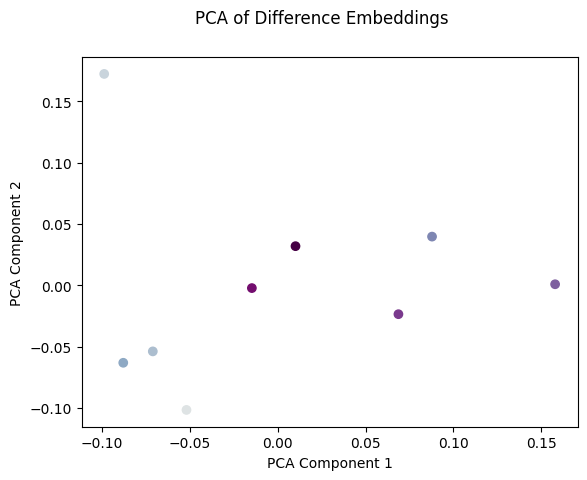

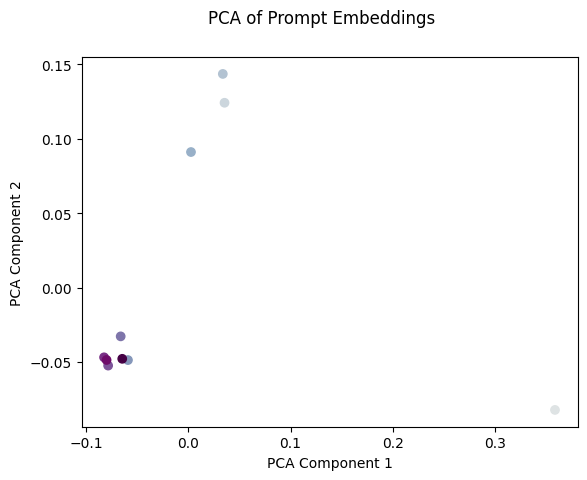

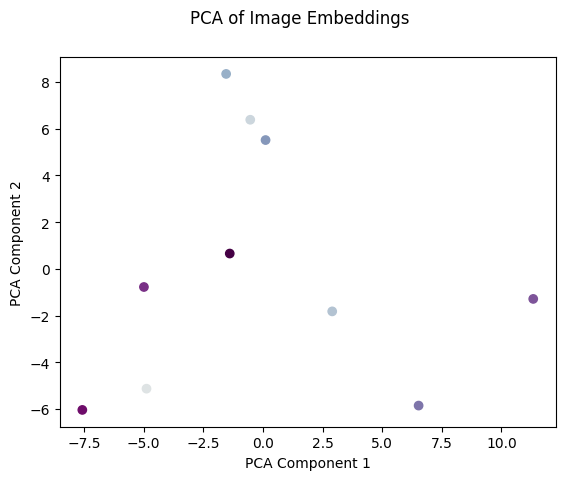

In [188]:
diff_pca = get_pca_plot(difference_embeddings, title = "PCA of Difference Embeddings")
prompt_pca = get_pca_plot(prompt_embeddings, title = "PCA of Prompt Embeddings")
img_pca = get_pca_plot(img_embeddings, title = "PCA of Image Embeddings")

## Similarity
Assuming that the last iteration has a matching prompt, determine the similarity in the iterations.

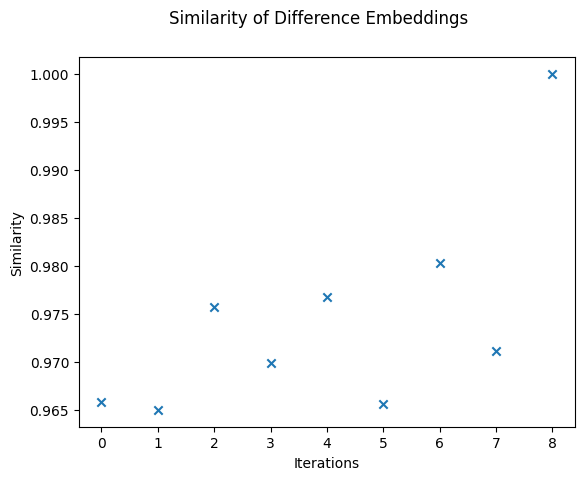

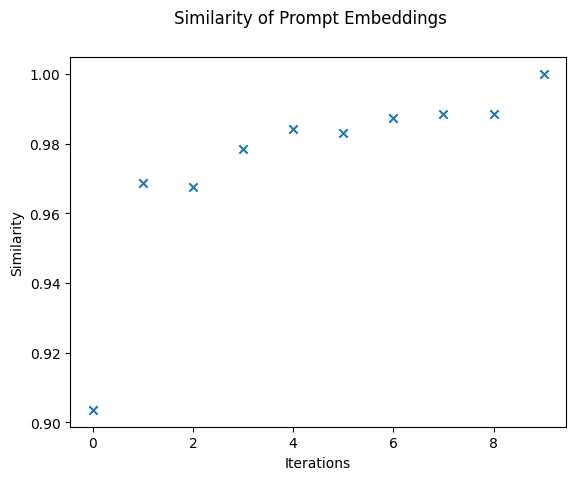

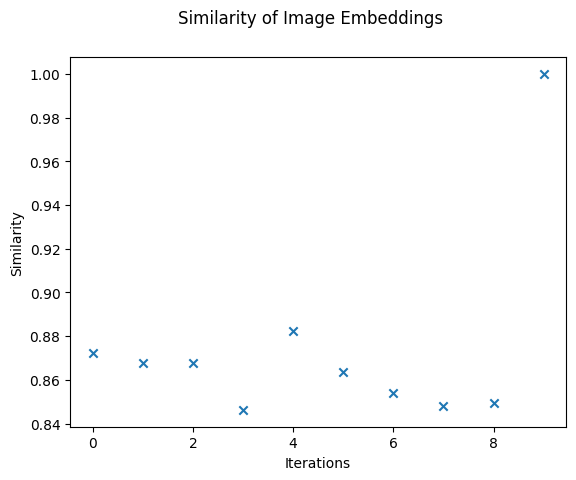

In [189]:
sim_diff = get_similarities(difference_embeddings, limit=False, title="Similarity of Difference Embeddings")
sim_prompt = get_similarities(prompt_embeddings, limit=False, title="Similarity of Prompt Embeddings")
sim_img = get_similarities(img_embeddings, limit=False, title="Similarity of Image Embeddings")




# More Plots

tbd: box plots, mean of img and prompt, relation between img and prompt, comparison of different runs, comparison between all runs?, alignment score? (derivative with positive vals only?)

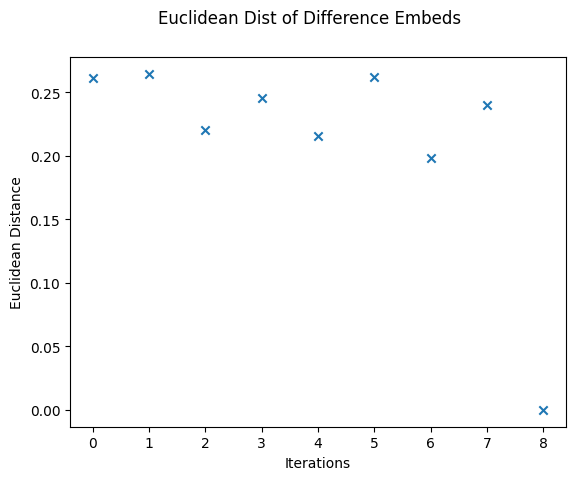

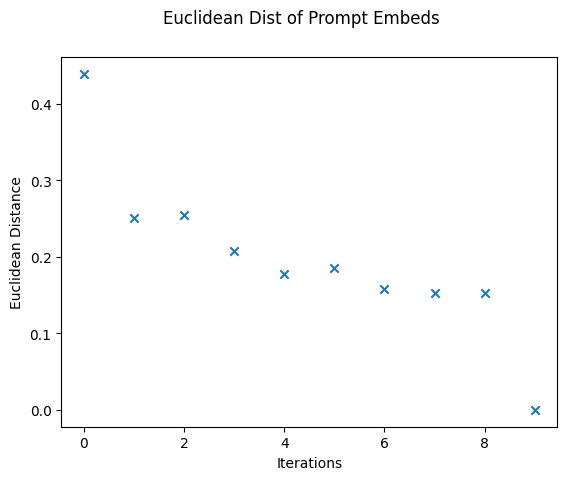

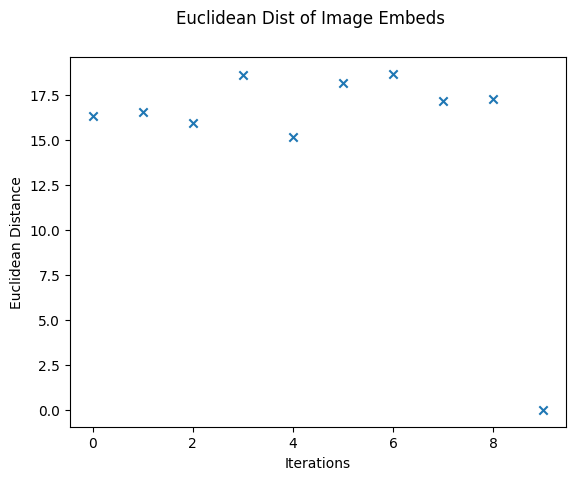

In [190]:
eucl_dist_diff = get_euclidean_distances(difference_embeddings, title="Euclidean Dist of Difference Embeds")
eucl_dist_prompt = get_euclidean_distances(prompt_embeddings, title="Euclidean Dist of Prompt Embeds")
eucl_dist_img = get_euclidean_distances(img_embeddings, title="Euclidean Dist of Image Embeds")

In [191]:
print(f"shape img: {np.array(img_embeddings).shape}")
print(f"shape prompt: {np.array(prompt_embeddings).shape}")

print(f"dtype img: {np.array(img_embeddings).dtype}")
print(f"dtype prompt: {np.array(prompt_embeddings).dtype}")

print(f"range img: {np.min(img_embeddings)} - {np.max(img_embeddings)}")
print(f"range prompt: {np.min(prompt_embeddings)} - {np.max(prompt_embeddings)}")

shape img: (10, 512)
shape prompt: (10, 1536)
dtype img: float32
dtype prompt: float64
range img: 0.0 - 7.253933429718018
range prompt: -0.6946152448654175 - 0.2270698845386505


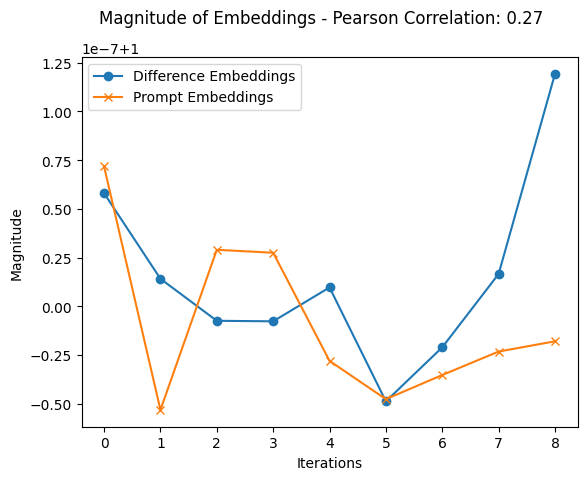

In [192]:
pears_img_prompt = plot_embedding_magnitudes_with_correlation(difference_embeddings, prompt_embeddings[1:], title="Magnitude of Embeddings")

In [193]:
embedding_stability_img = normalized_embedding_instability(img_embeddings)
embedding_stability_prompt = normalized_embedding_instability(prompt_embeddings)
embedding_stability_diff = normalized_embedding_instability(difference_embeddings)

# a lower embedding instability means that the embeddings are more stable
print(f"embedding instability img: {embedding_stability_img}")
print(f"embedding instability prompt: {embedding_stability_prompt}")
print(f"embedding instability diff: {embedding_stability_diff}")

convergence_img = measure_constant_increase(img_embeddings)
convergence_prompt = measure_constant_increase(prompt_embeddings)
convergence_diff = measure_constant_increase(difference_embeddings)

print(f"convergence img: {convergence_img}")
print(f"convergence prompt: {convergence_prompt}")
print(f"convergence diff: {convergence_diff}")

embedding instability img: 0.18229421610623542
embedding instability prompt: 0.08200696352350248
embedding instability diff: 0.037027396970137606
convergence img: 0.014202700927853584
convergence prompt: 0.010720073674594635
convergence diff: 0.004275661602765199


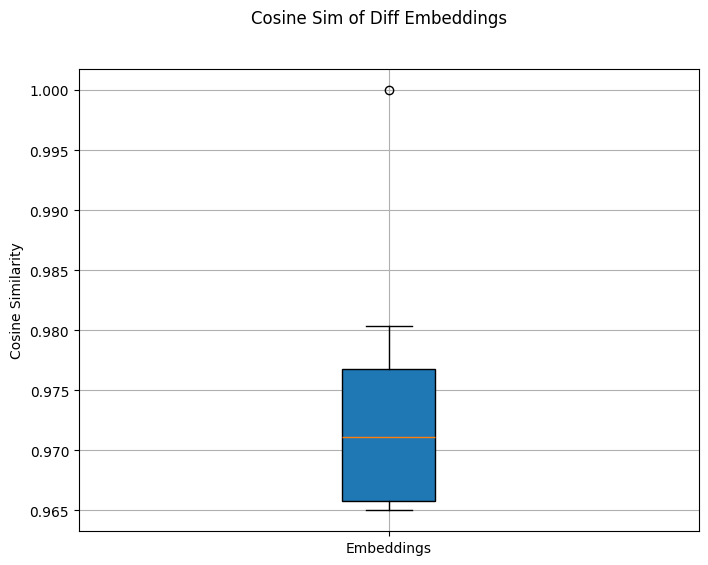

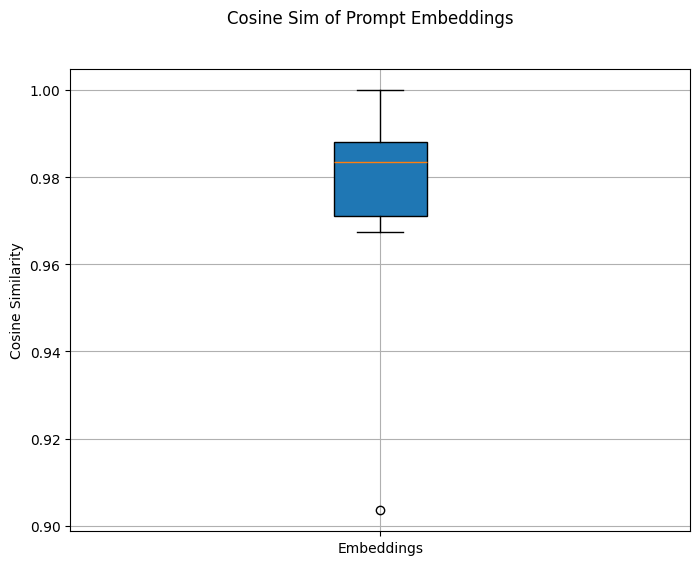

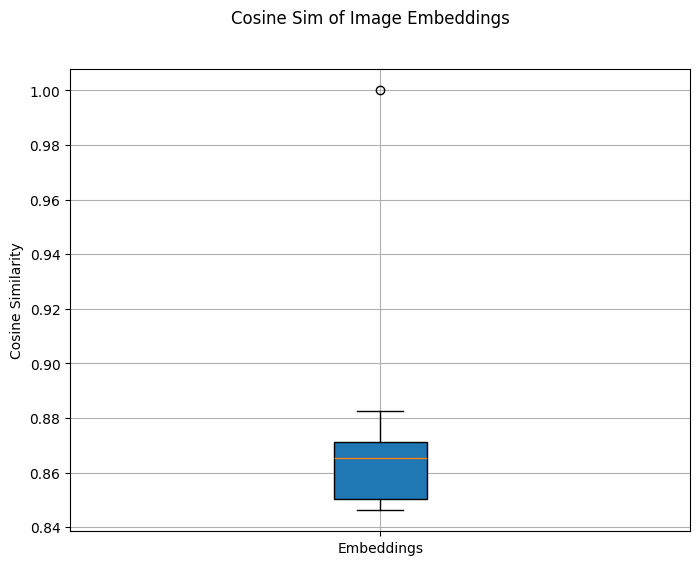

In [194]:
cos_box_diff = get_cosine_similarity_boxplot(difference_embeddings, title="Cosine Sim of Diff Embeddings")
cos_box_prompt = get_cosine_similarity_boxplot(prompt_embeddings, title="Cosine Sim of Prompt Embeddings")
cos_box_img = get_cosine_similarity_boxplot(img_embeddings, title="Cosine Sim of Image Embeddings")